basic algorithms on this dataset

NO idea : fgan1 and fgan2  ... need more in detail

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Convolution1D, UpSampling1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os

# Labels
LABELS = ['chat', 'email', 'file', 'streaming', 'voip']

# Parameters
latent_dim = 39
epochs = 5
batch_size = 64
numOfIterations = 10
numOfClients = 10
learning_rate = 0.0002
input_dim = 66  # Keeping the same input size as in AECNN

# --------------------- Model Definitions ---------------------

def build_encoder():
    input_e = Input(shape=(input_dim, 1))
    x = Convolution1D(64, 3, activation="relu", padding="same")(input_e)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    latent = Dense(latent_dim, activation="relu")(x)
    encoder = Model(input_e, latent, name="Encoder")
    return encoder

def build_decoder():
    input_d = Input(shape=(latent_dim,))
    x = Dense(input_dim)(input_d)
    x = Reshape((input_dim, 1))(x)
    x = UpSampling1D(size=2)(x)
    x = Convolution1D(64, 3, activation="relu", padding="same")(x)
    output = Convolution1D(1, 3, activation="sigmoid", padding="same")(x)
    decoder = Model(input_d, output, name="Decoder")
    return decoder

def build_generator():
    input_g = Input(shape=(latent_dim,))
    x = Dense(128, activation="relu")(input_g)
    x = Dense(256, activation="relu")(x)
    x = Dense(512, activation="relu")(x)
    x = Dense(latent_dim, activation="tanh")(x)  # Output must match latent_dim
    generator = Model(input_g, x, name="Generator")
    return generator

def build_discriminator():
    input_d = Input(shape=(latent_dim,))
    x = Dense(512, activation="relu")(input_d)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)  # Output probability
    discriminator = Model(input_d, x, name="Discriminator")
    return discriminator

# --------------------- Data Loading ---------------------

# Load dataset
dfDS = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')
X_full = dfDS.iloc[:, 1:].values
Y_full = dfDS["label"].values
num_classes = len(set(Y_full))

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(X_full, Y_full, test_size=0.10, random_state=523)

# Expand dims to match (input_dim, 1)
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

# --------------------- Model Initialization ---------------------

encoder = build_encoder()
decoder = build_decoder()
generator = build_generator()
discriminator = build_discriminator()

# Compile discriminator
discriminator.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

# --------------------- Federated Training ---------------------

for iteration in range(numOfIterations):
    print(f"Starting Federated Round {iteration + 1}/{numOfIterations}")

    for client in range(numOfClients):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_samples = encoder.predict(x_train[idx])  # Encoded real data

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator.predict(noise)  # Generated fake data

        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        # **Fix: Ensure Discriminator is Trainable Before Training**
        discriminator.trainable = True
        discriminator.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # **Fix: Freeze Discriminator When Training Generator**
        discriminator.trainable = False
        gan_input = Input(shape=(latent_dim,))
        gan_output = discriminator(generator(gan_input))
        gan = Model(gan_input, gan_output)
        gan.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy')

        g_loss = gan.train_on_batch(noise, real_labels)

    print(f"Iteration {iteration}: D Loss = {d_loss[0]}, G Loss = {g_loss}")

# --------------------- Save Trained Models ---------------------
encoder.save("FGAN-I_Encoder.keras")
decoder.save("FGAN-I_Decoder.keras")
generator.save("FGAN-I_Generator.keras")
discriminator.save("FGAN-I_Discriminator.keras")

print("Federated Training Completed. Models saved successfully.")


Starting Federated Round 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Iteration 0: D Loss = 0.6984218955039978, G Loss = 0.6131482124328613
Starting Federated Round 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

FileNotFoundError: [Errno 2] No such file or directory: './Models/FGAN-I_Encoder.keras'

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Convolution1D, UpSampling1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os

# Labels
#LABELS = ['TikTok', 'YouTube', 'Amazon', 'Instagram', 'Spotify', 'WhatsApp', 'Flipkart', 'Sound Cloud Music', 'Elden Ring', 'Telegram']
LABELS=['chat','email','file','streaming','voip']
# Parameters
latent_dim = 39
epochs = 5
batch_size = 64
numOfIterations = 10
numOfClients = 10
learning_rate = 0.0002
input_dim = 66  # Keeping the same input size as in AECNN

# --------------------- Model Definitions ---------------------

def build_encoder():
    """Builds the Encoder model (same as in AECNN)."""
    input_e = Input(shape=(input_dim, 1))
    x = Convolution1D(64, 3, activation="relu", padding="same")(input_e)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    latent = Dense(latent_dim, activation="relu")(x)
    encoder = Model(input_e, latent, name="Encoder")
    return encoder

def build_decoder():
    """Builds the Decoder model (same as in AECNN)."""
    input_d = Input(shape=(latent_dim,))
    x = Dense(input_dim)(input_d)
    x = Reshape((input_dim, 1))(x)
    x = UpSampling1D(size=2)(x)
    x = Convolution1D(64, 3, activation="relu", padding="same")(x)
    output = Convolution1D(1, 3, activation="sigmoid", padding="same")(x)
    decoder = Model(input_d, output, name="Decoder")
    return decoder

def build_generator():
    """Builds the Generator model (output matches Encoder latent space)."""
    input_g = Input(shape=(latent_dim,))
    x = Dense(128, activation="relu")(input_g)
    x = Dense(256, activation="relu")(x)
    x = Dense(512, activation="relu")(x)
    x = Dense(latent_dim, activation="tanh")(x)  # Must match Encoder output
    generator = Model(input_g, x, name="Generator")
    return generator

def build_discriminator():
    """Builds the Discriminator model (input matches Encoder output)."""
    input_d = Input(shape=(latent_dim,))
    x = Dense(512, activation="relu")(input_d)
    x = Dense(256, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)  # Output probability
    discriminator = Model(input_d, x, name="Discriminator")
    return discriminator

# --------------------- Data Loading ---------------------

# Load dataset
dfDS = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')
X_full = dfDS.iloc[:, 1:].values
Y_full = dfDS["label"].values
num_classes = len(set(Y_full))

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(X_full, Y_full, test_size=0.10, random_state=523)

# Expand dims to match (input_dim, 1)
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

# --------------------- Model Initialization ---------------------

encoder = build_encoder()
decoder = build_decoder()

# Create a common model architecture
common_generator = build_generator()
common_discriminator = build_discriminator()

# Initialize client models with identical architecture
client_generators = [tf.keras.models.clone_model(common_generator) for _ in range(numOfClients)]
client_discriminators = [tf.keras.models.clone_model(common_discriminator) for _ in range(numOfClients)]

# Compile all discriminators (lower learning rate)
for d in client_discriminators:
    d.compile(optimizer=Adam(learning_rate * 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# --------------------- Federated Training ---------------------
for iteration in range(numOfIterations):
    print(f"Starting Federated Round {iteration + 1}/{numOfIterations}")

    # Initialize weight aggregations
    aggregated_G_weights = np.array(client_generators[0].get_weights(), dtype=object)
    aggregated_D_weights = np.array(client_discriminators[0].get_weights(), dtype=object)

    for client in range(numOfClients):
        generator = client_generators[client]
        discriminator = client_discriminators[client]

        # Create GAN model for the client
        discriminator.trainable = False
        gan_input = Input(shape=(latent_dim,))
        gan_output = discriminator(generator(gan_input))
        gan = Model(gan_input, gan_output)
        gan.compile(optimizer=Adam(learning_rate), loss='mean_squared_error')  # Use MSE loss

        # Train on a batch of real and fake data
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_samples = encoder.predict(x_train[idx])  # Encoded real data

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_samples = generator.predict(noise)  # Generated fake data

        # One-sided label smoothing
        real_labels = np.random.uniform(0.8, 1.0, (batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        # Random label flipping (10% chance)
        if np.random.rand() < 0.1:
            real_labels, fake_labels = fake_labels, real_labels

        # Train discriminator
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        discriminator.trainable = False

        # Train generator multiple times per step
        for _ in range(3):
            g_loss = gan.train_on_batch(noise, real_labels)

        print(f"Client {client + 1} | D Loss = {d_loss[0]:.4f}, G Loss = {g_loss:.4f}")

        # Aggregate model weights
        aggregated_G_weights += np.array(generator.get_weights(), dtype=object)
        aggregated_D_weights += np.array(discriminator.get_weights(), dtype=object)

    # Federated Averaging (FedAvg)
    aggregated_G_weights /= numOfClients
    aggregated_D_weights /= numOfClients

    # Update all clients with the aggregated weights
    for client in range(numOfClients):
        client_generators[client].set_weights(aggregated_G_weights)
        client_discriminators[client].set_weights(aggregated_D_weights)

    print(f"Iteration {iteration}: Updated Federated Model")

# --------------------- Save Trained Models ---------------------
encoder.save("FGAN-II_Encoder.keras")
decoder.save("FGAN-II_Decoder.keras")
client_generators[0].save("FGAN-II_Generator.keras")
client_discriminators[0].save("FGAN-II_Discriminator.keras")

print("Federated Training Completed. Models saved successfully.")


SSM using autoencoder and classifier CNN ans SSM using gans ans classifier CNN


Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.6393 - val_loss: 0.5642
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5658 - val_loss: 0.5566
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5700 - val_loss: 0.5553
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5648 - val_loss: 0.5559
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5721 - val_loss: 0.5551
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5682 - val_loss: 0.5553
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5718 - val_loss: 0.5551
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5816 - val_loss: 0.5536
Epoch 9/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5858 - val_loss: 0.5529
Epoch 10/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5673 - val_loss: 0.5531
Epoch 11/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5819 - val_loss: 0.5529
Epoch 12/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

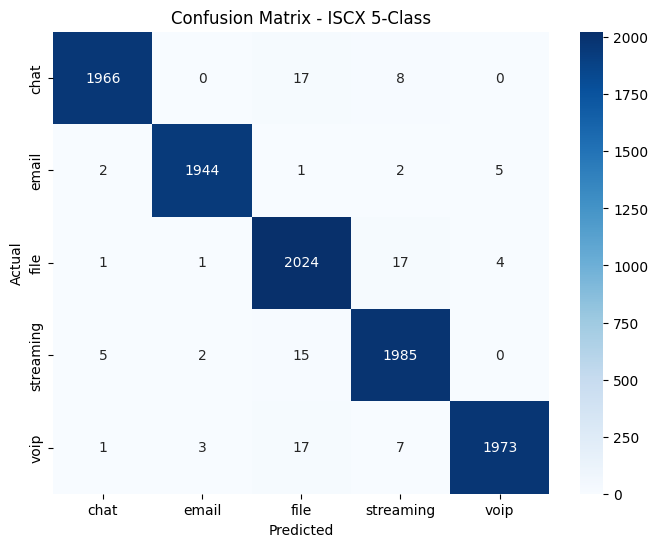

In [ ]:
# -*- coding: utf-8 -*-
"""
Experiment 1 - ISCX 5-Class Dataset
Feature Extraction using Autoencoder (VAE) + CNN Classification
"""

import numpy as np
import pandas as pd
import time
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Convolution1D, MaxPooling1D, Flatten, Reshape
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Labels for ISCX 5-Class dataset
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']

# Load ISCX dataset
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')

# Extract features and labels
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude first column (assuming it's an index)
Y_ISCX = df_ISCX["label"].values     # Target labels

# Normalize data
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(X_ISCX, Y_ISCX, test_size=0.1, random_state=5)

# Convert labels to categorical (one-hot encoding)
num_classes = len(set(Y_ISCX))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Define Autoencoder (VAE) for Feature Extraction
latent_dim = 39
input_dim = X_ISCX.shape[1]

# Encoder
input_e = Input(shape=(input_dim,))
x = Dense(512, activation="relu")(input_e)
x = Dense(256, activation="relu")(x)
x = Dense(latent_dim, activation="relu")(x)
encoder = Model(input_e, x, name="encoder")

# Decoder
input_d = Input(shape=(latent_dim,))
x = Dense(256, activation="relu")(input_d)
x = Dense(512, activation="relu")(x)
x = Dense(input_dim, activation="sigmoid")(x)
decoder = Model(input_d, x, name="decoder")

# Combine Autoencoder
autoencoder = Model(input_e, decoder(encoder(input_e)))
autoencoder.compile(optimizer="adam", loss="mse")

# Train Autoencoder
autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test))

# Extract Features
x_train_encoded = encoder.predict(x_train)
x_test_encoded = encoder.predict(x_test)

# Define CNN Classifier
input_c = Input(shape=(latent_dim,))
x = Dense(128, activation="relu")(input_c)
x = Dense(64, activation="relu")(x)
x = Dense(num_classes, activation="softmax")(x)
cnn = Model(input_c, x, name="CNN_classifier")
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train CNN
cnn.fit(x_train_encoded, y_train, epochs=50, batch_size=128, validation_data=(x_test_encoded, y_test))

# Evaluate CNN
y_pred = cnn.predict(x_test_encoded)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Print classification report
print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels, target_names=LABELS_ISCX))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ISCX 5-Class")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0: D Loss = 0.7164, D Acc = 0.3906, G Loss = 0.7130
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30

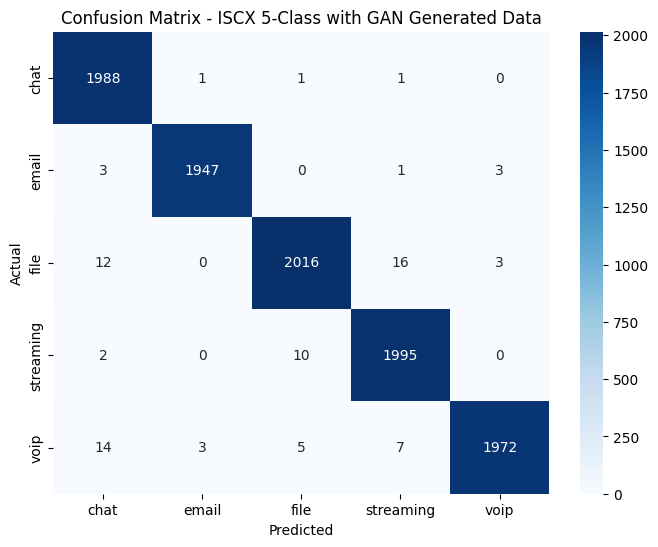

In [ ]:
# -*- coding: utf-8 -*-
"""
Experiment 1 - ISCX 5-Class Dataset
Synthetic Data Generation using GANs
"""

import numpy as np
import pandas as pd
import time
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Labels for ISCX 5-Class dataset
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']

# Load ISCX dataset
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')

# Extract features and labels
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude first column (assuming it's an index)
Y_ISCX = df_ISCX["label"].values     # Target labels

# Normalize data
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(X_ISCX, Y_ISCX, test_size=0.1, random_state=5)

# Convert labels to categorical (one-hot encoding)
num_classes = len(set(Y_ISCX))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# GAN Parameters
latent_dim = 100  # Size of noise vector

# Generator Model
def build_generator():
    input_g = Input(shape=(latent_dim,))
    x = Dense(256)(input_g)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(512)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(X_ISCX.shape[1], activation="tanh")(x)  # Output same size as features
    generator = Model(input_g, x, name="Generator")
    return generator

# Discriminator Model
def build_discriminator():
    input_d = Input(shape=(X_ISCX.shape[1],))
    x = Dense(512)(input_d)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(1, activation="sigmoid")(x)  # Binary classification (Real or Fake)
    discriminator = Model(input_d, x, name="Discriminator")
    return discriminator

# Build and Compile GAN
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=["accuracy"])

# Combine into GAN
discriminator.trainable = False  # Freeze discriminator when training GAN
gan_input = Input(shape=(latent_dim,))
fake_data = generator(gan_input)
gan_output = discriminator(fake_data)
gan = Model(gan_input, gan_output)
gan.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))

# Training GAN
epochs = 500
batch_size = 64
half_batch = batch_size // 2

for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, x_train.shape[0], half_batch)
    real_data = x_train[idx]

    noise = np.random.normal(0, 1, (half_batch, latent_dim))
    generated_data = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(real_data, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(generated_data, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    # Print Training Progress
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: D Loss = {d_loss[0]:.4f}, D Acc = {d_loss[1]:.4f}, G Loss = {g_loss:.4f}")

# Generate Synthetic Data
num_samples = 5000  # Number of synthetic samples
noise = np.random.normal(0, 1, (num_samples, latent_dim))
synthetic_data = generator.predict(noise)

# Assign random labels to synthetic data (for semi-supervised learning)
synthetic_labels = np.random.randint(0, num_classes, num_samples)
synthetic_labels = tf.keras.utils.to_categorical(synthetic_labels, num_classes)

# Combine with real data
X_combined = np.vstack((x_train, synthetic_data))
Y_combined = np.vstack((y_train, synthetic_labels))

# Train CNN with Synthetic Data
input_c = Input(shape=(X_ISCX.shape[1],))
x = Dense(128, activation="relu")(input_c)
x = Dense(64, activation="relu")(x)
x = Dense(num_classes, activation="softmax")(x)
cnn = Model(input_c, x, name="CNN_classifier")
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

cnn.fit(X_combined, Y_combined, epochs=50, batch_size=128, validation_data=(x_test, y_test))

# Evaluate CNN
y_pred = cnn.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Print classification report
print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels, target_names=LABELS_ISCX))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ISCX 5-Class with GAN Generated Data")
plt.show()


federated ssm cnn and autoencoder


📌 Training Autoencoder...
Epoch 1/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.6302 - val_loss: 0.5580
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.5497 - val_loss: 0.5541
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.5650 - val_loss: 0.5536
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.5597 - val_loss: 0.5506
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.5601 - val_loss: 0.5471
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.5594 - val_loss: 0.5468
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.5607 - val_loss: 0.5465
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.5613 - val_loss: 0.5465
Epoch 9/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.5665 - val_loss: 0.5470
Epoch 10/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.5604 - val_loss: 0.5465
Epoch 11/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.5560 - val_loss: 0.5466
Epoch 1

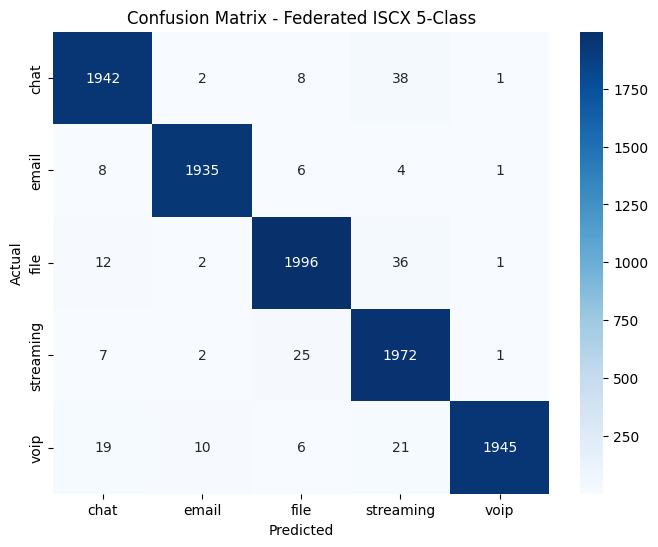

In [ ]:
# -*- coding: utf-8 -*-
"""
Federated Learning - ISCX 5-Class Dataset
Feature Extraction using Autoencoder (VAE) + CNN Classification
"""

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Labels for ISCX 5-Class dataset
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']
num_classes = len(LABELS_ISCX)

# 🔹 Load ISCX dataset
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')

# 🔹 Extract features and labels
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude first column
Y_ISCX = df_ISCX["label"].values     # Target labels

# 🔹 Normalize data
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# 🔹 Split dataset
x_train, x_test, y_train, y_test = train_test_split(X_ISCX, Y_ISCX, test_size=0.1, random_state=5)

# 🔹 Convert labels to categorical (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# 🔹 Define Autoencoder (VAE) for Feature Extraction
latent_dim = 39
input_dim = X_ISCX.shape[1]

# 🔹 Encoder
input_e = Input(shape=(input_dim,))
x = Dense(512, activation="relu")(input_e)
x = Dense(256, activation="relu")(x)
x = Dense(latent_dim, activation="relu")(x)
encoder = Model(input_e, x, name="encoder")

# 🔹 Decoder
input_d = Input(shape=(latent_dim,))
x = Dense(256, activation="relu")(input_d)
x = Dense(512, activation="relu")(x)
x = Dense(input_dim, activation="sigmoid")(x)
decoder = Model(input_d, x, name="decoder")

# 🔹 Combine Autoencoder
autoencoder = Model(input_e, decoder(encoder(input_e)))
autoencoder.compile(optimizer="adam", loss="mse")

# 🔹 Train Autoencoder
print("\n📌 Training Autoencoder...")
autoencoder.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test), verbose=1)

# 🔹 Extract Features
x_train_encoded = encoder.predict(x_train)
x_test_encoded = encoder.predict(x_test)

# 🔹 Federated Learning Setup
num_clients = 5
client_data_size = len(x_train) // num_clients
client_models = []

# 🔹 Define CNN Classifier
def create_classifier():
    input_c = Input(shape=(latent_dim,))
    x = Dense(128, activation="relu")(input_c)
    x = Dense(64, activation="relu")(x)
    x = Dense(num_classes, activation="softmax")(x)
    model = Model(input_c, x, name="CNN_classifier")
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# 🔹 Create Global Model
global_model = create_classifier()

# 🔹 Split Data Among Clients
encoded_client_data = np.array_split(x_train_encoded, num_clients)
client_labels = np.array_split(y_train, num_clients)

# 🔹 Train Local Models
for i in range(num_clients):
    print(f"\n📌 Training Client {i+1} Model...")
    local_model = create_classifier()  # 🔹 Ensure each client gets a compiled model
    local_model.set_weights(global_model.get_weights())  # 🔹 Start with global model weights
    local_model.fit(encoded_client_data[i], client_labels[i], epochs=5, batch_size=32, verbose=1)
    client_models.append(local_model)

# 🔹 Federated Averaging (FedAvg)
def fed_avg(models):
    """Perform Federated Averaging"""
    client_weights = [np.array(model.get_weights(), dtype=object) for model in models]
    avg_weights = np.mean(client_weights, axis=0)
    return avg_weights

# 🔹 Update Global Model
global_model.set_weights(fed_avg(client_models))

# 🔹 Evaluate Global Model
y_pred = global_model.predict(x_test_encoded)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# 🔹 Print Classification Report
print("\n📌 Global Model - Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=LABELS_ISCX))

# 🔹 Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Federated ISCX 5-Class")
plt.show()


federated ssm gans and cnn

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



🔹 Training GAN for Client 1/10...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Client 0 - Epoch 0: D Loss = 0.6527, G Loss = 0.7473
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Client 0 - Epoch 10: D Loss = 0.7748, G Loss = 0.5538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Client 0 - Epoch 20: D Loss = 0.9102, G Loss = 0.4200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1

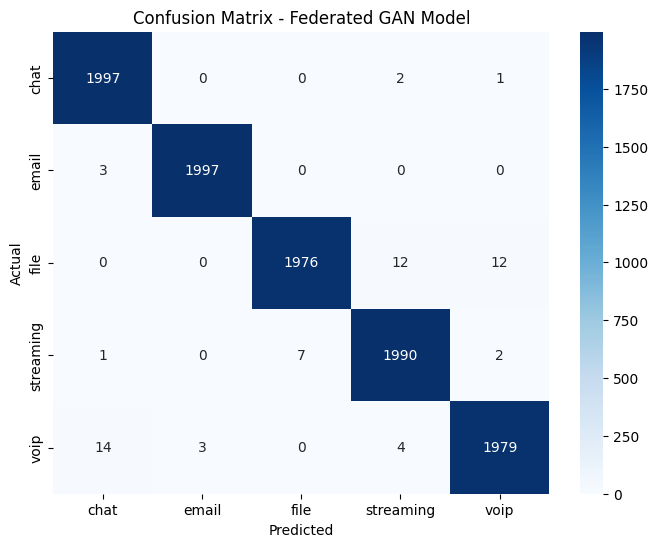

In [ ]:
# -*- coding: utf-8 -*-
"""
Federated Learning - GAN-based Synthetic Data Generation
"""

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Labels for ISCX 5-Class dataset
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']

# 📌 Load ISCX dataset
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')

# 📌 Extract features & labels
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude first column
Y_ISCX = df_ISCX["label"].values     # Target labels

# 📌 Normalize data
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# 📌 Split dataset (90% train, 10% test)
x_train, x_test, y_train, y_test = train_test_split(X_ISCX, Y_ISCX, test_size=0.1, stratify=Y_ISCX, random_state=5)

# 📌 Convert labels to categorical (one-hot encoding)
num_classes = len(set(Y_ISCX))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Federated Learning Parameters
NUM_CLIENTS = 10
EPOCHS = 100
BATCH_SIZE = 64
latent_dim = 100

# ==========================
# 🔹 Define Generator Model
# ==========================
def build_generator():
    input_g = Input(shape=(latent_dim,))
    x = Dense(256)(input_g)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(X_ISCX.shape[1], activation="tanh")(x)  # Output same size as features
    generator = Model(input_g, x, name="Generator")
    return generator

# ==========================
# 🔹 Define Discriminator Model
# ==========================
def build_discriminator():
    input_d = Input(shape=(X_ISCX.shape[1],))
    x = Dense(512)(input_d)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation="sigmoid")(x)  # Binary classification (Real or Fake)
    discriminator = Model(input_d, x, name="Discriminator")
    return discriminator

# ==========================
# 🔹 Federated Learning Setup (Each Client has a GAN)
# ==========================
client_gan = []
client_generators = []
client_discriminators = []

for _ in range(NUM_CLIENTS):
    gen = build_generator()
    disc = build_discriminator()

    # Compile Discriminator
    disc.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=["accuracy"])

    # Build GAN
    disc.trainable = False
    gan_input = Input(shape=(latent_dim,))
    fake_data = gen(gan_input)
    gan_output = disc(fake_data)
    gan = Model(gan_input, gan_output)
    gan.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))

    client_gan.append(gan)
    client_generators.append(gen)
    client_discriminators.append(disc)

# 📌 Split training data for each client
client_data = np.array_split(x_train, NUM_CLIENTS)
client_labels = np.array_split(y_train, NUM_CLIENTS)

# ==========================
# 🔹 Train Clients (GANs)
# ==========================
for client_id in range(NUM_CLIENTS):
    print(f"\n🔹 Training GAN for Client {client_id + 1}/{NUM_CLIENTS}...")

    half_batch = BATCH_SIZE // 2
    for epoch in range(EPOCHS):
        # Train Discriminator
        idx = np.random.randint(0, client_data[client_id].shape[0], half_batch)
        real_data = client_data[client_id][idx]

        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        generated_data = client_generators[client_id].predict(noise)

        d_loss_real = client_discriminators[client_id].train_on_batch(real_data, np.ones((half_batch, 1)))
        d_loss_fake = client_discriminators[client_id].train_on_batch(generated_data, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (BATCH_SIZE, latent_dim))
        g_loss = client_gan[client_id].train_on_batch(noise, np.ones((BATCH_SIZE, 1)))

        if epoch % 10 == 0:
            print(f"Client {client_id} - Epoch {epoch}: D Loss = {d_loss[0]:.4f}, G Loss = {g_loss:.4f}")

# ==========================
# 🔹 Federated Averaging (FedAvg)
# ==========================
def federated_aggregation(models):
    new_weights = []
    for layer_idx in range(len(models[0].get_weights())):
        layer_weights = np.mean([model.get_weights()[layer_idx] for model in models], axis=0)
        new_weights.append(layer_weights)
    return new_weights

# Aggregate GANs
aggregated_generator_weights = federated_aggregation(client_generators)
for gen in client_generators:
    gen.set_weights(aggregated_generator_weights)

# Generate Synthetic Data
num_samples = 5000
noise = np.random.normal(0, 1, (num_samples, latent_dim))
synthetic_data = client_generators[0].predict(noise)
synthetic_labels = np.random.randint(0, num_classes, num_samples)
synthetic_labels = tf.keras.utils.to_categorical(synthetic_labels, num_classes)

# ==========================
# 🔹 Train CNN Classifier on Real + Synthetic Data
# ==========================
X_combined = np.vstack((x_train, synthetic_data))
Y_combined = np.vstack((y_train, synthetic_labels))

input_c = Input(shape=(X_ISCX.shape[1],))
x = Dense(128, activation="relu")(input_c)
x = Dense(64, activation="relu")(x)
x = Dense(num_classes, activation="softmax")(x)
cnn = Model(input_c, x, name="CNN_classifier")
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

cnn.fit(X_combined, Y_combined, epochs=50, batch_size=128, validation_data=(x_test, y_test))

# ==========================
# 🔹 Evaluate Global Model
# ==========================
y_pred = cnn.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("\n📌 Global Model - Classification Report:\n", classification_report(y_true_labels, y_pred_labels, target_names=LABELS_ISCX))


# 📌 Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Federated GAN Model")
plt.show()


🔹 Training GAN for Client 1/10...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


743/743 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8065 - loss: 0.6308 - val_accuracy: 0.9763 - val_loss: 0.0836
Epoch 2/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9388 - loss: 0.1518 - val_accuracy: 0.9832 - val_loss: 0.0512
Epoch 3/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9430 - loss: 0.1316 - val_accuracy: 0.9854 - val_loss: 0.0411
Epoch 4/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9451 - loss: 0.1253 - val_accuracy: 0.9888 - val_loss: 0.0351
Epoch 5/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9461 - loss: 0.1206 - val_accuracy: 0.9892 - val_loss: 0.0314
Epoch 6/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9484 - loss: 0.1149 - val_accuracy: 0.9873 - val_loss: 0.0383
Epoch 7/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9470 - loss: 0.1165 - val_accuracy: 0.9902 - val_loss: 0.0255
Epoch 8/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9485 - loss: 0.1146 - val_accuracy: 0.9898 - val_

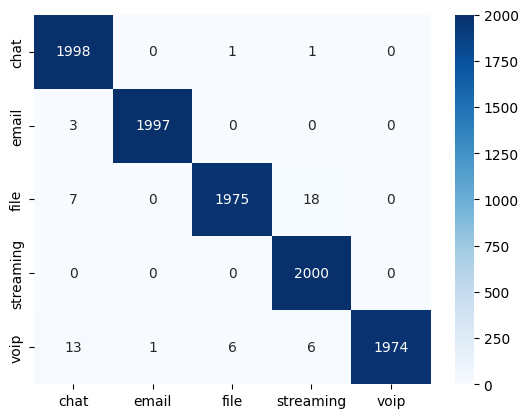

In [ ]:
# -*- coding: utf-8 -*-
"""
Federated Semi-Supervised GAN (FGAN-I) for ISCX 5-Class Dataset
"""

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Labels for ISCX 5-Class dataset
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']

# 🔹 Load ISCX dataset
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')

# 🔹 Extract features & labels
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude first column
Y_ISCX = df_ISCX["label"].values     # Target labels

# 🔹 Normalize data
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# 🔹 Split dataset
x_train, x_test, y_train, y_test = train_test_split(X_ISCX, Y_ISCX, test_size=0.1, stratify=Y_ISCX, random_state=5)

# 🔹 Convert labels to categorical (one-hot encoding)
num_classes = len(set(Y_ISCX))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# 🔹 Federated Learning Parameters
NUM_CLIENTS = 10
EPOCHS = 50
BATCH_SIZE = 128
LATENT_DIM = 100  # Size of noise vector for GAN

# ==========================
# 🔹 Define Generator
# ==========================
def build_generator():
    input_g = Input(shape=(LATENT_DIM,))
    x = Dense(256)(input_g)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(512)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(X_ISCX.shape[1], activation="tanh")(x)  # Output same size as features
    generator = Model(input_g, x, name="Generator")
    return generator

# ==========================
# 🔹 Define Discriminator
# ==========================
def build_discriminator():
    input_d = Input(shape=(X_ISCX.shape[1],))
    x = Dense(512)(input_d)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(1, activation="sigmoid")(x)  # Binary classification (Real or Fake)
    discriminator = Model(input_d, x, name="Discriminator")
    discriminator.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=["accuracy"])
    return discriminator

# ==========================
# 🔹 Federated Learning Setup
# ==========================
client_generators = []
client_discriminators = []

for _ in range(NUM_CLIENTS):
    gen = build_generator()
    disc = build_discriminator()
    client_generators.append(gen)
    client_discriminators.append(disc)

# 🔹 Split training data for each client
client_data = np.array_split(x_train, NUM_CLIENTS)
client_labels = np.array_split(y_train, NUM_CLIENTS)

# ==========================
# 🔹 Train Federated GAN
# ==========================
for client_id in range(NUM_CLIENTS):
    print(f"\n🔹 Training GAN for Client {client_id + 1}/{NUM_CLIENTS}...")

    generator = client_generators[client_id]
    discriminator = client_discriminators[client_id]

    # 📌 Compile Generator and GAN before training
    generator.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))

    # 📌 Create and compile the full GAN model
    discriminator.trainable = False  # Freeze Discriminator for GAN training
    gan_input = Input(shape=(LATENT_DIM,))
    generated_samples = generator(gan_input)
    gan_output = discriminator(generated_samples)
    gan = Model(gan_input, gan_output)
    gan.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))

    # 📌 Train Discriminator with Label Smoothing
    half_batch = BATCH_SIZE // 2
    for epoch in range(EPOCHS):
        idx = np.random.randint(0, client_data[client_id].shape[0], half_batch)
        real_samples = client_data[client_id][idx]
        real_labels = np.ones((half_batch, 1)) * 0.9  # Label smoothing

        noise = np.random.normal(0, 1, (half_batch, LATENT_DIM))
        generated_samples = generator.predict(noise)
        fake_labels = np.zeros((half_batch, 1)) + 0.1  # Fake label smoothing

        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # 📌 Train Generator through GAN
        noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
        g_loss = gan.train_on_batch(noise, np.ones((BATCH_SIZE, 1)))

    print(f"📌 Client {client_id + 1}: D Loss = {d_loss[0]:.4f}, G Loss = {g_loss:.4f}")

# ==========================
# 🔹 Federated Aggregation (FedAvg)
# ==========================
def federated_aggregation(models):
    """ Aggregates weights using FedAvg (Federated Averaging) """
    new_weights = []
    for layer_idx in range(len(models[0].get_weights())):
        layer_weights = np.mean([model.get_weights()[layer_idx] for model in models], axis=0)
        new_weights.append(layer_weights)
    return new_weights

# 📌 Aggregate Generator & Discriminator Weights
aggregated_gen_weights = federated_aggregation(client_generators)
aggregated_disc_weights = federated_aggregation(client_discriminators)

# 📌 Apply Aggregated Weights
for gen in client_generators:
    gen.set_weights(aggregated_gen_weights)
for disc in client_discriminators:
    disc.set_weights(aggregated_disc_weights)

# ==========================
# 🔹 Generate Synthetic Data & Train CNN
# ==========================
num_samples = 5000
noise = np.random.normal(0, 1, (num_samples, LATENT_DIM))
synthetic_data = client_generators[0].predict(noise)
synthetic_labels = np.random.randint(0, num_classes, num_samples)
synthetic_labels = tf.keras.utils.to_categorical(synthetic_labels, num_classes)

X_combined = np.vstack((x_train, synthetic_data))
Y_combined = np.vstack((y_train, synthetic_labels))

cnn = tf.keras.models.Sequential([
    Dense(128, activation="relu", input_shape=(X_ISCX.shape[1],)),
    Dense(64, activation="relu"),
    Dense(num_classes, activation="softmax")
])
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
cnn.fit(X_combined, Y_combined, epochs=50, batch_size=128, validation_data=(x_test, y_test))

# 📌 Confusion Matrix
y_pred = cnn.predict(x_test)
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.show()



🔹 Training GAN for Client 1/10...


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


📌 Client 1: D Loss = 1.1769, G Loss = 0.2293

🔹 Training GAN for Client 2/10...
📌 Client 2: D Loss = 1.0836, G Loss = 0.3177

🔹 Training GAN for Client 3/10...
📌 Client 3: D Loss = 1.0847, G Loss = 0.2562

🔹 Training GAN for Client 4/10...
📌 Client 4: D Loss = 1.0868, G Loss = 0.2688

🔹 Training GAN for Client 5/10...
📌 Client 5: D Loss = 1.0451, G Loss = 0.3188

🔹 Training GAN for Client 6/10...
📌 Client 6: D Loss = 1.0860, G Loss = 0.2691

🔹 Training GAN for Client 7/10...
📌 Client 7: D Loss = 1.1473, G Loss = 0.2169

🔹 Training GAN for Client 8/10...
📌 Client 8: D Loss = 1.0912, G Loss = 0.2694

🔹 Training GAN for Client 9/10...
📌 Client 9: D Loss = 1.0545, G Loss = 0.3478

🔹 Training GAN for Client 10/10...
📌 Client 10: D Loss = 1.1142, G Loss = 0.2486
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


743/743 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8258 - loss: 0.6035 - val_accuracy: 0.9766 - val_loss: 0.0809
Epoch 2/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9388 - loss: 0.1517 - val_accuracy: 0.9841 - val_loss: 0.0502
Epoch 3/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9448 - loss: 0.1287 - val_accuracy: 0.9858 - val_loss: 0.0421
Epoch 4/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9474 - loss: 0.1235 - val_accuracy: 0.9841 - val_loss: 0.0475
Epoch 5/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9482 - loss: 0.1178 - val_accuracy: 0.9889 - val_loss: 0.0341
Epoch 6/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9478 - loss: 0.1154 - val_accuracy: 0.9896 - val_loss: 0.0309
Epoch 7/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9495 - loss: 0.1116 - val_accuracy: 0.9897 - val_loss: 0.0294
Epoch 8/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9493 - loss: 0.1113 - val_accuracy: 0.9910 - val_

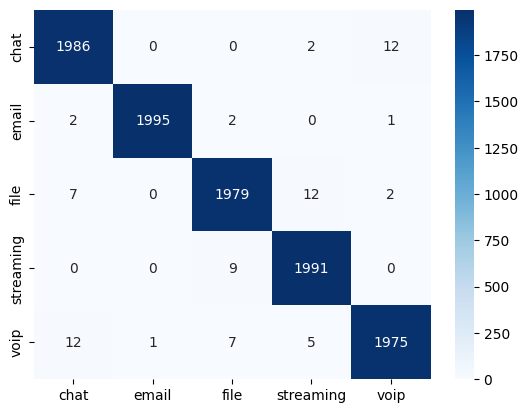

In [ ]:
# -*- coding: utf-8 -*-
"""
Federated Semi-Supervised GAN (FGAN-I) for ISCX 5-Class Dataset
"""

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Labels for ISCX 5-Class dataset
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']

# 🔹 Load ISCX dataset
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')

# 🔹 Extract features & labels
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude first column
Y_ISCX = df_ISCX["label"].values     # Target labels

# 🔹 Normalize data
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# 🔹 Split dataset
x_train, x_test, y_train, y_test = train_test_split(X_ISCX, Y_ISCX, test_size=0.1, stratify=Y_ISCX, random_state=5)

# 🔹 Convert labels to categorical (one-hot encoding)
num_classes = len(set(Y_ISCX))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# 🔹 Federated Learning Parameters
NUM_CLIENTS = 10
EPOCHS = 50
BATCH_SIZE = 128
LATENT_DIM = 100  # Size of noise vector for GAN

# ==========================
# 🔹 Define Generator
# ==========================
def build_generator():
    input_g = Input(shape=(LATENT_DIM,))
    x = Dense(256)(input_g)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(512)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(X_ISCX.shape[1], activation="tanh")(x)  # Output same size as features
    generator = Model(input_g, x, name="Generator")
    return generator

# ==========================
# 🔹 Define Discriminator
# ==========================
def build_discriminator():
    input_d = Input(shape=(X_ISCX.shape[1],))
    x = Dense(512)(input_d)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(1, activation="sigmoid")(x)  # Binary classification (Real or Fake)
    discriminator = Model(input_d, x, name="Discriminator")
    return discriminator

# ==========================
# 🔹 Federated Learning Setup
# ==========================
client_generators = []
client_discriminators = []

for _ in range(NUM_CLIENTS):
    gen = build_generator()
    disc = build_discriminator()

    # 🔹 Compile Generator & Discriminator before training
    disc.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=["accuracy"])
    gen.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))

    client_generators.append(gen)
    client_discriminators.append(disc)

# 🔹 Split training data for each client
client_data = np.array_split(x_train, NUM_CLIENTS)
client_labels = np.array_split(y_train, NUM_CLIENTS)

# ==========================
# 🔹 Train Federated GAN
# ==========================
def train_gan(client_id):
    print(f"\n🔹 Training GAN for Client {client_id + 1}/{NUM_CLIENTS}...")

    generator = client_generators[client_id]
    discriminator = client_discriminators[client_id]

    # ✅ Re-compile the discriminator to ensure trainable weights
    discriminator.trainable = True
    discriminator.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=["accuracy"])

    # ✅ Define & Compile GAN
    discriminator.trainable = False  # Freeze Discriminator during GAN training
    gan_input = Input(shape=(LATENT_DIM,))
    generated_samples = generator(gan_input)
    gan_output = discriminator(generated_samples)
    gan = Model(gan_input, gan_output)
    gan.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))

    half_batch = BATCH_SIZE // 2
    for epoch in range(EPOCHS):
        idx = np.random.randint(0, client_data[client_id].shape[0], half_batch)
        real_samples = client_data[client_id][idx]
        real_labels = np.ones((half_batch, 1)) * 0.9  # Label smoothing

        noise = np.random.normal(0, 1, (half_batch, LATENT_DIM))
        generated_samples = generator(noise, training=True)  # ✅ FIXED `.predict()`

        fake_labels = np.zeros((half_batch, 1)) + 0.1  # Fake label smoothing

        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
        g_loss = gan.train_on_batch(noise, np.ones((BATCH_SIZE, 1)))

    print(f"📌 Client {client_id + 1}: D Loss = {d_loss[0]:.4f}, G Loss = {g_loss:.4f}")

# 🔹 Train all clients
for client_id in range(NUM_CLIENTS):
    train_gan(client_id)

# ==========================
# 🔹 Federated Aggregation (FedAvg)
# ==========================
def federated_aggregation(models):
    """ Aggregates weights using FedAvg (Federated Averaging) """
    new_weights = []
    for layer_idx in range(len(models[0].get_weights())):
        layer_weights = np.mean([model.get_weights()[layer_idx] for model in models], axis=0)
        new_weights.append(layer_weights)
    return new_weights

# 🔹 Aggregate Generator & Discriminator Weights
aggregated_gen_weights = federated_aggregation(client_generators)
aggregated_disc_weights = federated_aggregation(client_discriminators)

# 🔹 Apply Aggregated Weights
for gen in client_generators:
    gen.set_weights(aggregated_gen_weights)
for disc in client_discriminators:
    disc.set_weights(aggregated_disc_weights)

# ==========================
# 🔹 Generate Synthetic Data & Train CNN
# ==========================
num_samples = 5000
noise = np.random.normal(0, 1, (num_samples, LATENT_DIM))
synthetic_data = client_generators[0](noise, training=False)  # ✅ FIXED `.predict()`
synthetic_labels = np.random.randint(0, num_classes, num_samples)
synthetic_labels = tf.keras.utils.to_categorical(synthetic_labels, num_classes)

X_combined = np.vstack((x_train, synthetic_data))
Y_combined = np.vstack((y_train, synthetic_labels))

cnn = tf.keras.models.Sequential([
    Dense(128, activation="relu", input_shape=(X_ISCX.shape[1],)),
    Dense(64, activation="relu"),
    Dense(num_classes, activation="softmax")
])
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
cnn.fit(X_combined, Y_combined, epochs=50, batch_size=128, validation_data=(x_test, y_test))

# 🔹 Confusion Matrix
y_pred = cnn.predict(x_test)
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.show()


federated learning sgans

In [ ]:
# -*- coding: utf-8 -*-
"""
Federated Semi-Supervised GAN (SGAN) for ISCX 5-Class Dataset
"""

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Labels for ISCX 5-Class dataset
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']

# 🔹 Load ISCX dataset
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')

# 🔹 Extract features & labels
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude first column
Y_ISCX = df_ISCX["label"].values     # Target labels

# 🔹 Normalize data
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# 🔹 Split dataset
x_train, x_test, y_train, y_test = train_test_split(X_ISCX, Y_ISCX, test_size=0.1, stratify=Y_ISCX, random_state=5)

# 🔹 Convert labels to categorical (one-hot encoding)
num_classes = len(set(Y_ISCX))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# 🔹 Federated Learning Parameters
NUM_CLIENTS = 10
EPOCHS = 50
BATCH_SIZE = 128
LATENT_DIM = 100  # Size of noise vector for GAN

# ==========================
# 🔹 Define Generator
# ==========================
def build_generator():
    input_g = Input(shape=(LATENT_DIM,))
    x = Dense(256)(input_g)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(512)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(X_ISCX.shape[1], activation="tanh")(x)  # Output same size as features
    generator = Model(input_g, x, name="SGAN_Generator")
    return generator

# ==========================
# 🔹 Define Discriminator
# ==========================
def build_discriminator():
    input_d = Input(shape=(X_ISCX.shape[1],))
    x = Dense(512)(input_d)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(negative_slope=0.2)(x)
    x = Dense(1, activation="sigmoid")(x)  # ✅ Ensure output is (batch_size, 1)

    discriminator = Model(input_d, x, name="SGAN_Discriminator")
    return discriminator

# ==========================
# 🔹 Federated Learning Setup
# ==========================
client_generators = []
client_discriminators = []

for _ in range(NUM_CLIENTS):
    gen = build_generator()
    disc = build_discriminator()

    # 🔹 Compile Generator & Discriminator before training
    disc.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=["accuracy"])
    gen.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))

    client_generators.append(gen)
    client_discriminators.append(disc)

# 🔹 Split training data for each client
client_data = np.array_split(x_train, NUM_CLIENTS)
client_labels = np.array_split(y_train, NUM_CLIENTS)

# ==========================
# 🔹 Train Federated SGAN
# ==========================
def train_sgan(client_id):
    print(f"\n🔹 Training SGAN for Client {client_id + 1}/{NUM_CLIENTS}...")

    generator = client_generators[client_id]
    discriminator = client_discriminators[client_id]

    # ✅ Re-compile the discriminator to ensure trainable weights
    discriminator.trainable = True
    discriminator.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=["accuracy"])

    # ✅ Define & Compile GAN
    discriminator.trainable = False  # Freeze Discriminator during GAN training
    gan_input = Input(shape=(LATENT_DIM,))
    generated_samples = generator(gan_input)
    gan_output = discriminator(generated_samples)
    gan = Model(gan_input, gan_output)
    gan.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))

    half_batch = BATCH_SIZE // 2
    for epoch in range(EPOCHS):
        idx = np.random.randint(0, client_data[client_id].shape[0], half_batch)
        real_samples = client_data[client_id][idx]
        real_labels = np.ones((half_batch, 1)) * 0.9  # Smoothed real labels

        noise = np.random.normal(0, 1, (half_batch, LATENT_DIM))
        generated_samples = generator(noise, training=True)

        fake_labels = np.zeros((half_batch, 1)) + 0.1  # Fake label smoothing

        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
        g_loss = gan.train_on_batch(noise, np.ones((BATCH_SIZE, 1)))

    print(f"📌 Client {client_id + 1}: D Loss = {d_loss[0]:.4f}, G Loss = {g_loss:.4f}")

# 🔹 Train all clients
for client_id in range(NUM_CLIENTS):
    train_sgan(client_id)

# ==========================
# 🔹 Federated Aggregation (FedAvg)
# ==========================
def federated_aggregation(models):
    """ Aggregates weights using FedAvg (Federated Averaging) """
    new_weights = []
    for layer_idx in range(len(models[0].get_weights())):
        layer_weights = np.mean([model.get_weights()[layer_idx] for model in models], axis=0)
        new_weights.append(layer_weights)
    return new_weights

# 🔹 Aggregate Generator & Discriminator Weights
aggregated_gen_weights = federated_aggregation(client_generators)
aggregated_disc_weights = federated_aggregation(client_discriminators)

# 🔹 Apply Aggregated Weights
for gen in client_generators:
    gen.set_weights(aggregated_gen_weights)
for disc in client_discriminators:
    disc.set_weights(aggregated_disc_weights)

# ==========================
# 🔹 Generate Synthetic Data & Train SGAN Classifier
# ==========================
num_samples = 5000
noise = np.random.normal(0, 1, (num_samples, LATENT_DIM))
synthetic_data = client_generators[0](noise, training=False)
synthetic_labels = np.random.randint(0, num_classes, num_samples)
synthetic_labels = tf.keras.utils.to_categorical(synthetic_labels, num_classes)

X_combined = np.vstack((x_train, synthetic_data))
Y_combined = np.vstack((y_train, synthetic_labels))

# ✅ SGAN Classifier
sgan_classifier = tf.keras.models.Sequential([
    Dense(128, activation="relu", input_shape=(X_ISCX.shape[1],)),
    Dense(64, activation="relu"),
    Dense(num_classes, activation="softmax")
])
sgan_classifier.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
sgan_classifier.fit(X_combined, Y_combined, epochs=50, batch_size=128, validation_data=(x_test, y_test))



🔹 Training SGAN for Client 1/10...


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


📌 Client 1: D Loss = 1.0979, G Loss = 0.2668

🔹 Training SGAN for Client 2/10...
📌 Client 2: D Loss = 1.0802, G Loss = 0.2579

🔹 Training SGAN for Client 3/10...
📌 Client 3: D Loss = 1.1075, G Loss = 0.2431

🔹 Training SGAN for Client 4/10...
📌 Client 4: D Loss = 1.0841, G Loss = 0.2837

🔹 Training SGAN for Client 5/10...
📌 Client 5: D Loss = 1.0205, G Loss = 0.3129

🔹 Training SGAN for Client 6/10...
📌 Client 6: D Loss = 1.0738, G Loss = 0.2947

🔹 Training SGAN for Client 7/10...
📌 Client 7: D Loss = 1.0342, G Loss = 0.2959

🔹 Training SGAN for Client 8/10...
📌 Client 8: D Loss = 1.1043, G Loss = 0.2455

🔹 Training SGAN for Client 9/10...
📌 Client 9: D Loss = 1.0513, G Loss = 0.2900

🔹 Training SGAN for Client 10/10...
📌 Client 10: D Loss = 1.0860, G Loss = 0.2850
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8115 - loss: 0.6173 - val_accuracy: 0.9788 - val_loss: 0.0782
Epoch 2/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9374 - loss: 0.1506 - val_accuracy: 0.9822 - val_loss: 0.0590
Epoch 3/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9424 - loss: 0.1333 - val_accuracy: 0.9854 - val_loss: 0.0442
Epoch 4/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9447 - loss: 0.1253 - val_accuracy: 0.9853 - val_loss: 0.0423
Epoch 5/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9466 - loss: 0.1201 - val_accuracy: 0.9863 - val_loss: 0.0440
Epoch 6/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9472 - loss: 0.1176 - val_accuracy: 0.9889 - val_loss: 0.0332
Epoch 7/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9488 - loss: 0.1141 - val_accuracy: 0.9897 - val_loss: 0.0278
Epoch 8/50
743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9480 - loss: 0.1139 - val_accuracy: 0.9904 - val_

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

🔹 Classification Report:

              precision    recall  f1-score   support

        chat       0.99      1.00      0.99      2000
       email       1.00      1.00      1.00      2000
        file       0.99      0.99      0.99      2000
   streaming       0.99      1.00      0.99      2000
        voip       1.00      0.98      0.99      2000

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



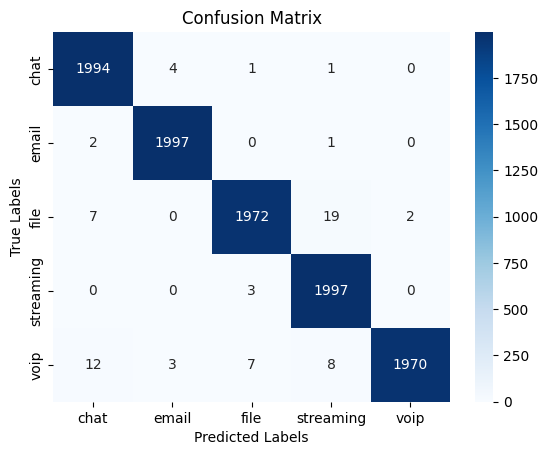

In [ ]:
# 🔹 Evaluate SGAN Classifier
y_pred = sgan_classifier.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 🔹 Print Classification Report
print("\n🔹 Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=LABELS_ISCX))

# 🔹 Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


proper
fgan1

Epoch 1/50 - Training Client 1/10
Client 1: D Loss = 0.6950, G Loss = 0.6610
Epoch 2/50 - Training Client 1/10
Client 1: D Loss = 0.6985, G Loss = 0.6328
Epoch 3/50 - Training Client 1/10
Client 1: D Loss = 0.6970, G Loss = 0.6125
Epoch 4/50 - Training Client 1/10
Client 1: D Loss = 0.6969, G Loss = 0.5957
Epoch 5/50 - Training Client 1/10
Client 1: D Loss = 0.6990, G Loss = 0.5834
Epoch 6/50 - Training Client 1/10
Client 1: D Loss = 0.7019, G Loss = 0.5725
Epoch 7/50 - Training Client 1/10
Client 1: D Loss = 0.7050, G Loss = 0.5637
Epoch 8/50 - Training Client 1/10
Client 1: D Loss = 0.7071, G Loss = 0.5549
Epoch 9/50 - Training Client 1/10
Client 1: D Loss = 0.7099, G Loss = 0.5464
Epoch 10/50 - Training Client 1/10
Client 1: D Loss = 0.7119, G Loss = 0.5397
Epoch 11/50 - Training Client 1/10
Client 1: D Loss = 0.7139, G Loss = 0.5335
Epoch 12/50 - Training Client 1/10
Client 1: D Loss = 0.7152, G Loss = 0.5273
Epoch 13/50 - Training Client 1/10
Client 1: D Loss = 0.7173, G Loss = 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


739/739 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8146 - loss: 0.5844 - val_accuracy: 0.6251 - val_loss: 0.8949
Epoch 2/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9802 - loss: 0.0694 - val_accuracy: 0.6228 - val_loss: 1.0730
Epoch 3/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9851 - loss: 0.0493 - val_accuracy: 0.6181 - val_loss: 1.3110
Epoch 4/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9872 - loss: 0.0404 - val_accuracy: 0.6173 - val_loss: 1.4967
Epoch 5/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9880 - loss: 0.0348 - val_accuracy: 0.6170 - val_loss: 1.6423
Epoch 6/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9886 - loss: 0.0334 - val_accuracy: 0.6183 - val_loss: 1.6948
Epoch 7/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9894 - loss: 0.0298 - val_accuracy: 0.6182 - val_loss: 1.8847
Epoch 8/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9895 - loss: 0.0298 - val_accuracy: 0.6173 - val_

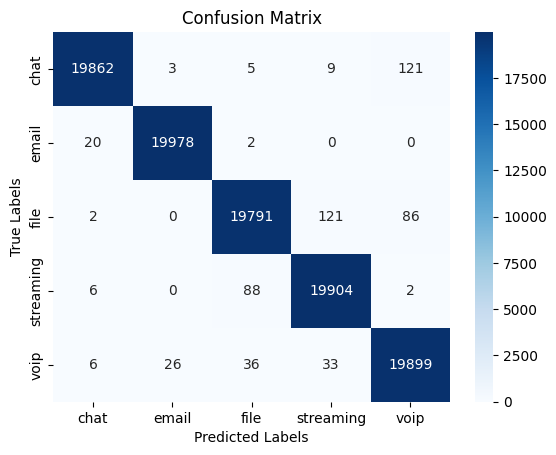

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# ==========================
# 🔹 Load and Preprocess Dataset
# ==========================
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude first column
Y_ISCX = df_ISCX["label"].values     # Target labels

# Normalize dataset
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# Convert labels to categorical
num_classes = len(set(Y_ISCX))
y_ISCX = tf.keras.utils.to_categorical(Y_ISCX, num_classes)

# ==========================
# 🔹 Define FGAN-I Components
# ==========================
LATENT_DIM = 100
NUM_CLIENTS = 10
BATCH_SIZE = 128
EPOCHS = 50

# Generator
def build_generator():
    input_g = Input(shape=(LATENT_DIM,))
    x = Dense(256)(input_g)
    x = LeakyReLU(0.2)(x)
    x = Dense(512)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(X_ISCX.shape[1], activation="tanh")(x)
    return Model(input_g, x, name="FGAN1_Generator")

# Discriminator
def build_discriminator():
    input_d = Input(shape=(X_ISCX.shape[1],))
    x = Dense(512)(input_d)
    x = LeakyReLU(0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    return Model(input_d, x, name="FGAN1_Discriminator")

# ==========================
# 🔹 Federated Learning Setup
# ==========================
client_generators = [build_generator() for _ in range(NUM_CLIENTS)]
client_discriminators = [build_discriminator() for _ in range(NUM_CLIENTS)]

for disc in client_discriminators:
    disc.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=["accuracy"])

client_data = np.array_split(X_ISCX, NUM_CLIENTS)
client_labels = np.array_split(y_ISCX, NUM_CLIENTS)

# ==========================
# 🔹 Train Federated FGAN-I
# ==========================
def train_fgan1(client_id):
    generator = client_generators[client_id]
    discriminator = client_discriminators[client_id]

    discriminator.trainable = True
    discriminator.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=["accuracy"])

    gan_input = Input(shape=(LATENT_DIM,))
    generated_samples = generator(gan_input)
    gan_output = discriminator(generated_samples)
    gan = Model(gan_input, gan_output)
    gan.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))

    half_batch = BATCH_SIZE // 2
    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS} - Training Client {client_id+1}/{NUM_CLIENTS}")
        idx = np.random.randint(0, client_data[client_id].shape[0], half_batch)
        real_samples = client_data[client_id][idx]
        real_labels = np.ones((half_batch, 1)) * 0.9
        noise = np.random.normal(0, 1, (half_batch, LATENT_DIM))
        generated_samples = generator(noise, training=True)
        fake_labels = np.zeros((half_batch, 1)) + 0.1

        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
        g_loss = gan.train_on_batch(noise, np.ones((BATCH_SIZE, 1)))

        print(f"Client {client_id+1}: D Loss = {d_loss[0]:.4f}, G Loss = {g_loss:.4f}")

# Train all clients
for client_id in range(NUM_CLIENTS):
    train_fgan1(client_id)

# ==========================
# 🔹 Federated Model Aggregation (FedAvg)
# ==========================
def federated_aggregation(models):
    new_weights = []
    for layer_idx in range(len(models[0].get_weights())):
        layer_weights = np.mean([model.get_weights()[layer_idx] for model in models], axis=0)
        new_weights.append(layer_weights)
    return new_weights

aggregated_gen_weights = federated_aggregation(client_generators)
aggregated_disc_weights = federated_aggregation(client_discriminators)

for gen in client_generators:
    gen.set_weights(aggregated_gen_weights)
for disc in client_discriminators:
    disc.set_weights(aggregated_disc_weights)


# ==========================
# 🔹 Train Traffic Classifier
# ==========================
def assign_pseudo_labels(generator, num_samples=5000):
    noise = np.random.normal(0, 1, (num_samples, LATENT_DIM))
    synthetic_data = generator(noise, training=False)
    kmeans = KMeans(n_clusters=num_classes, random_state=42)
    pseudo_labels = kmeans.fit_predict(synthetic_data)
    return synthetic_data, tf.keras.utils.to_categorical(pseudo_labels, num_classes)

synthetic_data, synthetic_labels = assign_pseudo_labels(client_generators[0])
X_combined = np.vstack((X_ISCX, synthetic_data))
Y_combined = np.vstack((y_ISCX, synthetic_labels))

classifier = tf.keras.models.Sequential([
    Dense(128, activation="relu", input_shape=(X_ISCX.shape[1],)),
    Dense(64, activation="relu"),
    Dense(num_classes, activation="softmax")
])
classifier.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
classifier.fit(X_combined, Y_combined, epochs=50, batch_size=128, validation_split=0.1)

# Evaluate Classifier
y_pred = classifier.predict(X_ISCX)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_ISCX, axis=1)
print(classification_report(y_true_classes, y_pred_classes, target_names=LABELS_ISCX))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

proper fgan2

Epoch 1/50 - Training Client 1/10
Client 1: D Loss = 0.7438, G Loss = 0.2412
Epoch 2/50 - Training Client 1/10
Client 1: D Loss = 0.6964, G Loss = 0.2262
Epoch 3/50 - Training Client 1/10
Client 1: D Loss = 0.6773, G Loss = 0.2106
Epoch 4/50 - Training Client 1/10
Client 1: D Loss = 0.6759, G Loss = 0.1943
Epoch 5/50 - Training Client 1/10
Client 1: D Loss = 0.6819, G Loss = 0.1775
Epoch 6/50 - Training Client 1/10
Client 1: D Loss = 0.6955, G Loss = 0.1617
Epoch 7/50 - Training Client 1/10
Client 1: D Loss = 0.7146, G Loss = 0.1472
Epoch 8/50 - Training Client 1/10
Client 1: D Loss = 0.7378, G Loss = 0.1344
Epoch 9/50 - Training Client 1/10
Client 1: D Loss = 0.7638, G Loss = 0.1234
Epoch 10/50 - Training Client 1/10
Client 1: D Loss = 0.7911, G Loss = 0.1141
Epoch 11/50 - Training Client 1/10
Client 1: D Loss = 0.8172, G Loss = 0.1061
Epoch 12/50 - Training Client 1/10
Client 1: D Loss = 0.8417, G Loss = 0.0990
Epoch 13/50 - Training Client 1/10
Client 1: D Loss = 0.8641, G Loss = 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


739/739 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8375 - loss: 0.5734 - val_accuracy: 0.6099 - val_loss: 1.0659
Epoch 2/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9798 - loss: 0.0720 - val_accuracy: 0.6217 - val_loss: 1.2145
Epoch 3/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9848 - loss: 0.0494 - val_accuracy: 0.6384 - val_loss: 1.3737
Epoch 4/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9876 - loss: 0.0385 - val_accuracy: 0.6127 - val_loss: 1.5157
Epoch 5/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9875 - loss: 0.0375 - val_accuracy: 0.6761 - val_loss: 1.6293
Epoch 6/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9889 - loss: 0.0344 - val_accuracy: 0.6695 - val_loss: 1.6467
Epoch 7/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9908 - loss: 0.0279 - val_accuracy: 0.6585 - val_loss: 1.7352
Epoch 8/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9904 - loss: 0.0284 - val_accuracy: 0.6651 - val_

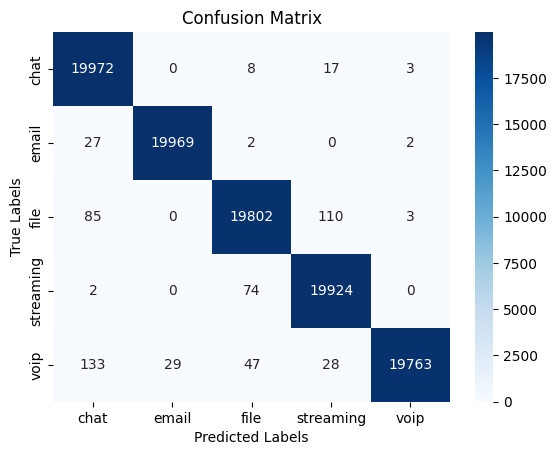

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.initializers import RandomNormal
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# ==========================
# 🔹 Load and Preprocess Dataset
# ==========================
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude first column (assumed to be an index)
Y_ISCX = df_ISCX["label"].values     # Extract target labels

# Normalize dataset
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# Convert labels to categorical (one-hot encoding)
num_classes = len(set(Y_ISCX))
y_ISCX = tf.keras.utils.to_categorical(Y_ISCX, num_classes)

# ==========================
# 🔹 Define FGAN-II Components
# ==========================
LATENT_DIM = 100  # Size of noise vector
NUM_CLIENTS = 10  # Number of clients in federated learning
BATCH_SIZE = 128
EPOCHS = 50
GENERATOR_UPDATES = 2  # More generator updates per epoch

# === Generator Model (Each Client has One) ===
def build_generator():
    input_g = Input(shape=(LATENT_DIM,))
    x = Dense(256, kernel_initializer=RandomNormal(stddev=0.02))(input_g)
    x = LeakyReLU(0.2)(x)
    x = Dense(512)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(X_ISCX.shape[1], activation="tanh")(x)  # Output shape matches dataset features
    return Model(input_g, x, name="FGAN2_Generator")

# === Discriminator Model (Each Client has One) ===
def build_discriminator():
    input_d = Input(shape=(X_ISCX.shape[1],))
    x = Dense(512)(input_d)
    x = LeakyReLU(0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(1, activation="sigmoid")(x)  # Binary classification: Real (1) or Fake (0)
    return Model(input_d, x, name="FGAN2_Discriminator")

# ==========================
# 🔹 Federated Learning Setup
# ==========================
# Each client has its own generator and discriminator
client_models = [{"G": build_generator(), "D": build_discriminator()} for _ in range(NUM_CLIENTS)]

# Compile all discriminators
for client in client_models:
    client["D"].compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=["accuracy"])

# Split dataset among clients
client_data = np.array_split(X_ISCX, NUM_CLIENTS)
client_labels = np.array_split(y_ISCX, NUM_CLIENTS)

# ==========================
# 🔹 Federated Training of FGAN-II
# ==========================
def train_fgan2(client_id):
    """ Train local GAN model at each client """
    generator = client_models[client_id]["G"]
    discriminator = client_models[client_id]["D"]

    gan_input = Input(shape=(LATENT_DIM,))
    generated_samples = generator(gan_input)
    gan_output = discriminator(generated_samples)
    gan = Model(gan_input, gan_output)
    gan.compile(loss="mean_squared_error", optimizer=Adam(0.0002, 0.5))

    half_batch = BATCH_SIZE // 2
    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS} - Training Client {client_id+1}/{NUM_CLIENTS}")

        idx = np.random.randint(0, client_data[client_id].shape[0], half_batch)
        real_samples = client_data[client_id][idx]
        real_labels = np.ones((half_batch, 1)) * 0.9  # One-sided label smoothing

        noise = np.random.normal(0, 1, (half_batch, LATENT_DIM))
        generated_samples = generator(noise, training=True)
        fake_labels = np.zeros((half_batch, 1)) + 0.1  # Fake label smoothing

        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        for _ in range(GENERATOR_UPDATES):
            noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
            g_loss = gan.train_on_batch(noise, np.ones((BATCH_SIZE, 1)))

        print(f"Client {client_id+1}: D Loss = {d_loss[0]:.4f}, G Loss = {g_loss:.4f}")

for client_id in range(NUM_CLIENTS):
    train_fgan2(client_id)

# ==========================
# 🔹 Federated Aggregation (FedAvg)
# ==========================
def federated_aggregation(models):
    new_weights = []
    for layer_idx in range(len(models[0].get_weights())):
        layer_weights = np.mean([model.get_weights()[layer_idx] for model in models], axis=0)
        new_weights.append(layer_weights)
    return new_weights

aggregated_gen_weights = federated_aggregation([client["G"] for client in client_models])
aggregated_disc_weights = federated_aggregation([client["D"] for client in client_models])

for client in client_models:
    client["G"].set_weights(aggregated_gen_weights)
    client["D"].set_weights(aggregated_disc_weights)

# ==========================
# 🔹 Deep Embedded Clustering (DEC)
# ==========================
def assign_pseudo_labels(generator, num_samples=5000):
    noise = np.random.normal(0, 1, (num_samples, LATENT_DIM))
    synthetic_data = generator(noise, training=False)
    gmm = GaussianMixture(n_components=num_classes, random_state=42)
    pseudo_labels = gmm.fit_predict(synthetic_data)
    return synthetic_data, tf.keras.utils.to_categorical(pseudo_labels, num_classes)

synthetic_data, synthetic_labels = assign_pseudo_labels(client_models[0]["G"])
X_combined = np.vstack((X_ISCX, synthetic_data))
Y_combined = np.vstack((y_ISCX, synthetic_labels))

classifier = tf.keras.models.Sequential([
    Dense(128, activation="relu", input_shape=(X_ISCX.shape[1],)),
    Dense(64, activation="relu"),
    Dense(num_classes, activation="softmax")
])
classifier.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
classifier.fit(X_combined, Y_combined, epochs=50, batch_size=128, validation_split=0.1)


# Evaluate Classifier
y_pred = classifier.predict(X_ISCX)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_ISCX, axis=1)
print(classification_report(y_true_classes, y_pred_classes, target_names=LABELS_ISCX))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

fgan2 with cnn classifier

Epoch 1/50 - Training Client 1/10
Client 1: D Loss = 0.6594, G Loss = 0.2394
Epoch 2/50 - Training Client 1/10
Client 1: D Loss = 0.6507, G Loss = 0.2272
Epoch 3/50 - Training Client 1/10
Client 1: D Loss = 0.6459, G Loss = 0.2148
Epoch 4/50 - Training Client 1/10
Client 1: D Loss = 0.6496, G Loss = 0.2018
Epoch 5/50 - Training Client 1/10
Client 1: D Loss = 0.6586, G Loss = 0.1884
Epoch 6/50 - Training Client 1/10
Client 1: D Loss = 0.6709, G Loss = 0.1744
Epoch 7/50 - Training Client 1/10
Client 1: D Loss = 0.6877, G Loss = 0.1607
Epoch 8/50 - Training Client 1/10
Client 1: D Loss = 0.7083, G Loss = 0.1479
Epoch 9/50 - Training Client 1/10
Client 1: D Loss = 0.7306, G Loss = 0.1364
Epoch 10/50 - Training Client 1/10
Client 1: D Loss = 0.7548, G Loss = 0.1263
Epoch 11/50 - Training Client 1/10
Client 1: D Loss = 0.7806, G Loss = 0.1174
Epoch 12/50 - Training Client 1/10
Client 1: D Loss = 0.8049, G Loss = 0.1098
Epoch 13/50 - Training Client 1/10
Client 1: D Loss = 0.8276, G Loss = 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.9058 - loss: 0.3325 - val_accuracy: 0.6109 - val_loss: 1.7526
Epoch 2/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9756 - loss: 0.0735 - val_accuracy: 0.6534 - val_loss: 1.4487
Epoch 3/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9823 - loss: 0.0526 - val_accuracy: 0.6792 - val_loss: 1.1563
Epoch 4/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9855 - loss: 0.0433 - val_accuracy: 0.6775 - val_loss: 1.8958
Epoch 5/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9864 - loss: 0.0390 - val_accuracy: 0.6837 - val_loss: 1.9277
Epoch 6/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9878 - loss: 0.0356 - val_accuracy: 0.6820 - val_loss: 1.1853
Epoch 7/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9882 - loss: 0.0343 - val_accuracy: 0.5666 - val_loss: 5.5033
Epoch 8/50
739/739 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9885 - loss: 0.0325 - val_accuracy: 

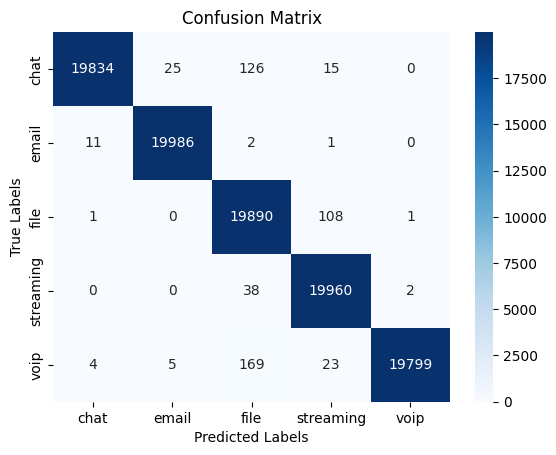

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.initializers import RandomNormal
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# ==========================
# 🔹 Load and Preprocess Dataset
# ==========================
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')
X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude first column (assumed to be an index)
Y_ISCX = df_ISCX["label"].values  # Extract target labels

# Normalize dataset
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# Convert labels to categorical (one-hot encoding)
num_classes = len(set(Y_ISCX))
y_ISCX = tf.keras.utils.to_categorical(Y_ISCX, num_classes)

# ==========================
# 🔹 Define FGAN-II Components
# ==========================
LATENT_DIM = 100  # Size of noise vector
NUM_CLIENTS = 10  # Number of clients in federated learning
BATCH_SIZE = 128
EPOCHS = 50
GENERATOR_UPDATES = 2  # More generator updates per epoch

# === Generator Model (Each Client has One) ===
def build_generator():
    input_g = Input(shape=(LATENT_DIM,))
    x = Dense(256, kernel_initializer=RandomNormal(stddev=0.02))(input_g)
    x = LeakyReLU(0.2)(x)
    x = Dense(512)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(X_ISCX.shape[1], activation="tanh")(x)  # Output shape matches dataset features
    return Model(input_g, x, name="FGAN2_Generator")

# === Discriminator Model (Each Client has One) ===
def build_discriminator():
    input_d = Input(shape=(X_ISCX.shape[1],))
    x = Dense(512)(input_d)
    x = LeakyReLU(0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(1, activation="sigmoid")(x)  # Binary classification: Real (1) or Fake (0)
    return Model(input_d, x, name="FGAN2_Discriminator")

# ==========================
# 🔹 Federated Learning Setup
# ==========================
# Each client has its own generator and discriminator
client_models = [{"G": build_generator(), "D": build_discriminator()} for _ in range(NUM_CLIENTS)]

# Compile all discriminators
for client in client_models:
    client["D"].compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=["accuracy"])

# Split dataset among clients
client_data = np.array_split(X_ISCX, NUM_CLIENTS)
client_labels = np.array_split(y_ISCX, NUM_CLIENTS)

# ==========================
# 🔹 Federated Training of FGAN-II
# ==========================
def train_fgan2(client_id):
    """ Train local GAN model at each client """
    generator = client_models[client_id]["G"]
    discriminator = client_models[client_id]["D"]

    gan_input = Input(shape=(LATENT_DIM,))
    generated_samples = generator(gan_input)
    gan_output = discriminator(generated_samples)
    gan = Model(gan_input, gan_output)
    gan.compile(loss="mean_squared_error", optimizer=Adam(0.0002, 0.5))

    half_batch = BATCH_SIZE // 2
    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS} - Training Client {client_id+1}/{NUM_CLIENTS}")

        idx = np.random.randint(0, client_data[client_id].shape[0], half_batch)
        real_samples = client_data[client_id][idx]
        real_labels = np.ones((half_batch, 1)) * 0.9  # One-sided label smoothing

        noise = np.random.normal(0, 1, (half_batch, LATENT_DIM))
        generated_samples = generator(noise, training=True)
        fake_labels = np.zeros((half_batch, 1)) + 0.1  # Fake label smoothing

        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        for _ in range(GENERATOR_UPDATES):
            noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
            g_loss = gan.train_on_batch(noise, np.ones((BATCH_SIZE, 1)))

        print(f"Client {client_id+1}: D Loss = {d_loss[0]:.4f}, G Loss = {g_loss:.4f}")

for client_id in range(NUM_CLIENTS):
    train_fgan2(client_id)

# ==========================
# 🔹 Federated Aggregation (FedAvg)
# ==========================
def federated_aggregation(models):
    new_weights = []
    for layer_idx in range(len(models[0].get_weights())):
        layer_weights = np.mean([model.get_weights()[layer_idx] for model in models], axis=0)
        new_weights.append(layer_weights)
    return new_weights

aggregated_gen_weights = federated_aggregation([client["G"] for client in client_models])
aggregated_disc_weights = federated_aggregation([client["D"] for client in client_models])

for client in client_models:
    client["G"].set_weights(aggregated_gen_weights)
    client["D"].set_weights(aggregated_disc_weights)

# ==========================
# 🔹 Deep Embedded Clustering (DEC)
# ==========================
def assign_pseudo_labels(generator, num_samples=5000):
    noise = np.random.normal(0, 1, (num_samples, LATENT_DIM))
    synthetic_data = generator(noise, training=False)
    gmm = GaussianMixture(n_components=num_classes, random_state=42)
    pseudo_labels = gmm.fit_predict(synthetic_data)
    return synthetic_data, tf.keras.utils.to_categorical(pseudo_labels, num_classes)

synthetic_data, synthetic_labels = assign_pseudo_labels(client_models[0]["G"])
X_combined = np.vstack((X_ISCX, synthetic_data))
Y_combined = np.vstack((y_ISCX, synthetic_labels))

# ==========================
# 🔹 CNN Classifier
# ==========================
input_shape = (X_ISCX.shape[1], 1)  # Reshape for Conv1D
X_combined_reshaped = np.expand_dims(X_combined, axis=-1)  # add channel dimension

classifier = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier.fit(X_combined_reshaped, Y_combined, epochs=50, batch_size=128, validation_split=0.1)

# Evaluate Classifier
X_ISCX_reshaped = np.expand_dims(X_ISCX, axis=-1)

y_pred = classifier.predict(X_ISCX_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_ISCX, axis=1)
print(classification_report(y_true_classes, y_pred_classes, target_names=LABELS_ISCX))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Epoch 1/50 - Training Client 1/10
Client 1: D Loss = 0.7939, G Loss = 0.1481
Epoch 2/50 - Training Client 1/10
Client 1: D Loss = 0.8303, G Loss = 0.1007
Epoch 3/50 - Training Client 1/10
Client 1: D Loss = 0.9199, G Loss = 0.0771
Epoch 4/50 - Training Client 1/10
Client 1: D Loss = 0.9956, G Loss = 0.0636
Epoch 5/50 - Training Client 1/10
Client 1: D Loss = 1.0589, G Loss = 0.0545
Epoch 6/50 - Training Client 1/10
Client 1: D Loss = 1.1168, G Loss = 0.0479
Epoch 7/50 - Training Client 1/10
Client 1: D Loss = 1.1576, G Loss = 0.0429
Epoch 8/50 - Training Client 1/10
Client 1: D Loss = 1.1913, G Loss = 0.0392
Epoch 9/50 - Training Client 1/10
Client 1: D Loss = 1.2211, G Loss = 0.0359
Epoch 10/50 - Training Client 1/10
Client 1: D Loss = 1.2479, G Loss = 0.0334
Epoch 11/50 - Training Client 1/10
Client 1: D Loss = 1.2689, G Loss = 0.0312
Epoch 12/50 - Training Client 1/10
Client 1: D Loss = 1.2861, G Loss = 0.0294
Epoch 13/50 - Training Client 1/10
Client 1: D Loss = 1.3036, G Loss = 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8087 - loss: 4.0461 - val_accuracy: 0.9876 - val_loss: 1.1297
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9454 - loss: 0.9926 - val_accuracy: 0.9932 - val_loss: 0.3555
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9580 - loss: 0.4005 - val_accuracy: 0.9889 - val_loss: 0.2074
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9637 - loss: 0.2688 - val_accuracy: 0.9930 - val_loss: 0.1555
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9673 - loss: 0.2262 - val_accuracy: 0.9899 - val_loss: 0.1564
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9698 - loss: 0.2119 - val_accuracy: 0.9903 - val_loss: 0.1389
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9713 - loss: 0.1958 - val_accuracy: 0.9920 - val_loss: 0.1390
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9722 - loss: 0.1919 - val_accuracy: 0.9897 - v

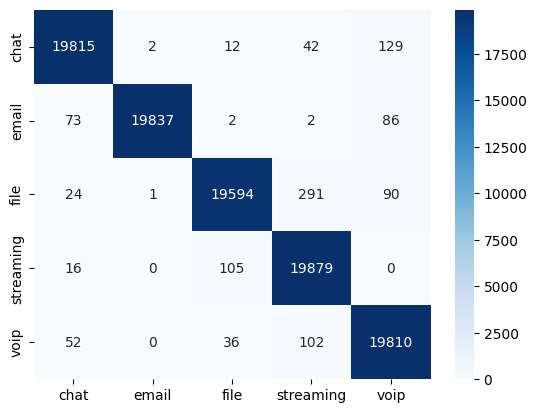

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.mixture import GaussianMixture

# ==========================
# 🔹 Load and Preprocess Dataset
# ==========================
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')

X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude first column (assumed to be an index)
Y_ISCX = df_ISCX["label"].values  # Extract target labels

# Normalize dataset
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# Convert labels to categorical (one-hot encoding)
num_classes = len(set(Y_ISCX))
y_ISCX = tf.keras.utils.to_categorical(Y_ISCX, num_classes)

# ==========================
# 🔹 Define FGAN-II Components
# ==========================
LATENT_DIM = 100
NUM_CLIENTS = 10
BATCH_SIZE = 128
EPOCHS = 50
GENERATOR_UPDATES = 3  # Increase generator updates to help catch up

# === Generator Model (Improved Stability) ===
def build_generator():
    input_g = Input(shape=(LATENT_DIM,))
    x = Dense(256, kernel_initializer="he_normal")(input_g)
    x = LeakyReLU(0.2)(x)
    x = Dense(512, kernel_initializer="he_normal")(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(X_ISCX.shape[1], activation="tanh")(x)
    return Model(input_g, x, name="FGAN2_Generator")

# === Discriminator Model (Slower Learning) ===
def build_discriminator():
    input_d = Input(shape=(X_ISCX.shape[1],))
    x = Dense(512, kernel_initializer="he_normal")(input_d)
    x = LeakyReLU(0.2)(x)
    x = Dense(256, kernel_initializer="he_normal")(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    return Model(input_d, x, name="FGAN2_Discriminator")

# ==========================
# 🔹 Federated Learning Setup
# ==========================
client_models = [{"G": build_generator(), "D": build_discriminator()} for _ in range(NUM_CLIENTS)]

# Compile all discriminators with a **lower learning rate**
for client in client_models:
    client["D"].compile(loss="binary_crossentropy", optimizer=Adam(0.0001, 0.5), metrics=["accuracy"])

client_data = np.array_split(X_ISCX, NUM_CLIENTS)
client_labels = np.array_split(y_ISCX, NUM_CLIENTS)

# ==========================
# 🔹 Federated Training of FGAN-II
# ==========================
def train_fgan2(client_id):
    generator = client_models[client_id]["G"]
    discriminator = client_models[client_id]["D"]

    gan_input = Input(shape=(LATENT_DIM,))
    generated_samples = generator(gan_input)
    gan_output = discriminator(generated_samples)
    gan = Model(gan_input, gan_output)
    gan.compile(loss="mean_squared_error", optimizer=Adam(0.0001, 0.5))

    half_batch = BATCH_SIZE // 2
    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS} - Training Client {client_id+1}/{NUM_CLIENTS}")

        idx = np.random.randint(0, client_data[client_id].shape[0], half_batch)
        real_samples = client_data[client_id][idx]
        real_labels = np.ones((half_batch, 1)) * 0.95

        noise = np.random.normal(0, 1, (half_batch, LATENT_DIM))
        generated_samples = generator(noise, training=True)
        fake_labels = np.zeros((half_batch, 1)) + 0.05

        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        for _ in range(GENERATOR_UPDATES):
            noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
            g_loss = gan.train_on_batch(noise, np.ones((BATCH_SIZE, 1)))

        print(f"Client {client_id+1}: D Loss = {d_loss[0]:.4f}, G Loss = {g_loss:.4f}")

for client_id in range(NUM_CLIENTS):
    train_fgan2(client_id)

# ==========================
# 🔹 Improved CNN Classifier
# ==========================
input_shape = (X_ISCX.shape[1], 1)
X_ISCX_reshaped = np.expand_dims(X_ISCX, axis=-1)

classifier = Sequential([
    Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

classifier.compile(optimizer=Adam(0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

classifier.fit(X_ISCX_reshaped, y_ISCX, epochs=50, batch_size=128, validation_split=0.1, callbacks=[early_stopping])

y_pred = classifier.predict(X_ISCX_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_ISCX, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=LABELS_ISCX))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.show()


Epoch 1/50 - Training Client 1/10
Client 1: D Loss = 0.9284, G Loss = 0.3979
Epoch 2/50 - Training Client 1/10
Client 1: D Loss = 0.8147, G Loss = 0.2740
Epoch 3/50 - Training Client 1/10
Client 1: D Loss = 0.8357, G Loss = 0.2057
Epoch 4/50 - Training Client 1/10
Client 1: D Loss = 0.8920, G Loss = 0.1645
Epoch 5/50 - Training Client 1/10
Client 1: D Loss = 0.9460, G Loss = 0.1381
Epoch 6/50 - Training Client 1/10
Client 1: D Loss = 0.9917, G Loss = 0.1197
Epoch 7/50 - Training Client 1/10
Client 1: D Loss = 1.0348, G Loss = 0.1058
Epoch 8/50 - Training Client 1/10
Client 1: D Loss = 1.0739, G Loss = 0.0952
Epoch 9/50 - Training Client 1/10
Client 1: D Loss = 1.1041, G Loss = 0.0872
Epoch 10/50 - Training Client 1/10
Client 1: D Loss = 1.1301, G Loss = 0.0806
Epoch 11/50 - Training Client 1/10
Client 1: D Loss = 1.1549, G Loss = 0.0748
Epoch 12/50 - Training Client 1/10
Client 1: D Loss = 1.1733, G Loss = 0.0700
Epoch 13/50 - Training Client 1/10
Client 1: D Loss = 1.1938, G Loss = 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


704/704 ━━━━━━━━━━━━━━━━━━━━ 17s 12ms/step - accuracy: 0.7814 - loss: 6.6373 - val_accuracy: 0.9854 - val_loss: 1.6182
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9329 - loss: 1.3480 - val_accuracy: 0.9878 - val_loss: 0.4626
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9514 - loss: 0.5026 - val_accuracy: 0.9879 - val_loss: 0.2720
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9596 - loss: 0.3397 - val_accuracy: 0.9880 - val_loss: 0.2350
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9661 - loss: 0.2890 - val_accuracy: 0.9889 - val_loss: 0.2162
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9698 - loss: 0.2622 - val_accuracy: 0.9896 - val_loss: 0.1883
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9699 - loss: 0.2458 - val_accuracy: 0.9883 - val_loss: 0.1944
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9725 - loss: 0.2322 - val_accuracy: 0.9939 - v

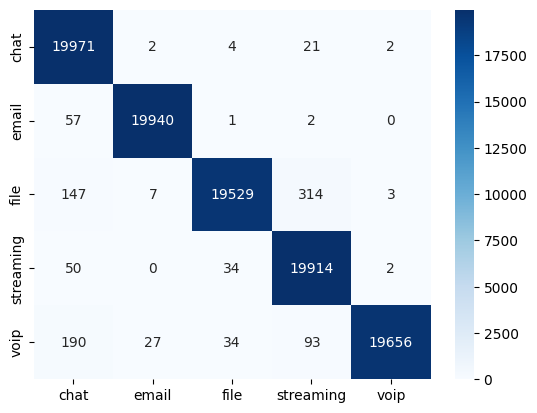

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# ==========================
# 🔹 Load and Preprocess Dataset
# ==========================
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')

X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude first column (assumed to be an index)
Y_ISCX = df_ISCX["label"].values  # Extract target labels

# Normalize dataset
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# Convert labels to categorical (one-hot encoding)
num_classes = len(set(Y_ISCX))
y_ISCX = tf.keras.utils.to_categorical(Y_ISCX, num_classes)

# ==========================
# 🔹 Define FGAN-II Components
# ==========================
LATENT_DIM = 100
NUM_CLIENTS = 10
BATCH_SIZE = 128
EPOCHS = 50
GENERATOR_UPDATES = 3  # Generator trains multiple times per step

# === Generator Model (Improved Stability) ===
def build_generator():
    input_g = Input(shape=(LATENT_DIM,))
    x = Dense(256, kernel_initializer="he_normal")(input_g)
    x = LeakyReLU(0.2)(x)
    x = Dense(512, kernel_initializer="he_normal")(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(X_ISCX.shape[1], activation="tanh")(x)
    return Model(input_g, x, name="FGAN2_Generator")

# === Discriminator Model (Slower Learning, Regularized) ===
def build_discriminator():
    input_d = Input(shape=(X_ISCX.shape[1],))
    x = Dense(512, kernel_initializer="he_normal")(input_d)
    x = LeakyReLU(0.2)(x)
    x = Dense(256, kernel_initializer="he_normal")(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    return Model(input_d, x, name="FGAN2_Discriminator")

# ==========================
# 🔹 Federated Learning Setup
# ==========================
client_models = [{"G": build_generator(), "D": build_discriminator()} for _ in range(NUM_CLIENTS)]

# Compile all discriminators with a **lower learning rate**
for client in client_models:
    client["D"].compile(loss="binary_crossentropy", optimizer=Adam(0.0001, 0.5), metrics=["accuracy"])

client_data = np.array_split(X_ISCX, NUM_CLIENTS)
client_labels = np.array_split(y_ISCX, NUM_CLIENTS)

# ==========================
# 🔹 Federated Training of FGAN-II
# ==========================
def train_fgan2(client_id):
    generator = client_models[client_id]["G"]
    discriminator = client_models[client_id]["D"]

    gan_input = Input(shape=(LATENT_DIM,))
    generated_samples = generator(gan_input)
    gan_output = discriminator(generated_samples)
    gan = Model(gan_input, gan_output)
    gan.compile(loss="mean_squared_error", optimizer=Adam(0.0001, 0.5))

    half_batch = BATCH_SIZE // 2
    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS} - Training Client {client_id+1}/{NUM_CLIENTS}")

        idx = np.random.randint(0, client_data[client_id].shape[0], half_batch)
        real_samples = client_data[client_id][idx]
        real_samples += 0.1 * np.random.normal(size=real_samples.shape)  # Add noise
        real_labels = np.ones((half_batch, 1)) * 0.95  # Label smoothing

        noise = np.random.normal(0, 1, (half_batch, LATENT_DIM))
        generated_samples = generator(noise, training=True)
        fake_labels = np.zeros((half_batch, 1)) + 0.05  # Label smoothing

        # Train Discriminator (only when necessary)
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        for _ in range(GENERATOR_UPDATES):
            noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
            g_loss = gan.train_on_batch(noise, np.ones((BATCH_SIZE, 1)))

        print(f"Client {client_id+1}: D Loss = {d_loss[0]:.4f}, G Loss = {g_loss:.4f}")

for client_id in range(NUM_CLIENTS):
    train_fgan2(client_id)

# ==========================
# 🔹 Improved CNN Classifier
# ==========================
input_shape = (X_ISCX.shape[1], 1)
X_ISCX_reshaped = np.expand_dims(X_ISCX, axis=-1)

classifier = Sequential([
    Conv1D(64, 3, activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(256, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

classifier.compile(optimizer=Adam(0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

classifier.fit(X_ISCX_reshaped, y_ISCX, epochs=50, batch_size=128, validation_split=0.1, callbacks=[early_stopping])

# ==========================
# 🔹 Classification Report & Confusion Matrix
# ==========================
y_pred = classifier.predict(X_ISCX_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_ISCX, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=LABELS_ISCX))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.show()


Epoch 1/50 - Training Client 1/10
Client 1: D Loss = 0.7061, G Loss = 0.2403
Epoch 2/50 - Training Client 1/10
Client 1: D Loss = 0.7201, G Loss = 0.1696
Epoch 3/50 - Training Client 1/10
Client 1: D Loss = 0.8098, G Loss = 0.1293
Epoch 4/50 - Training Client 1/10
Client 1: D Loss = 0.9080, G Loss = 0.1043
Epoch 5/50 - Training Client 1/10
Client 1: D Loss = 0.9721, G Loss = 0.0885
Epoch 6/50 - Training Client 1/10
Client 1: D Loss = 1.0238, G Loss = 0.0775
Epoch 7/50 - Training Client 1/10
Client 1: D Loss = 1.0700, G Loss = 0.0691
Epoch 8/50 - Training Client 1/10
Client 1: D Loss = 1.1068, G Loss = 0.0628
Epoch 9/50 - Training Client 1/10
Client 1: D Loss = 1.1402, G Loss = 0.0572
Epoch 10/50 - Training Client 1/10
Client 1: D Loss = 1.1720, G Loss = 0.0529
Epoch 11/50 - Training Client 1/10
Client 1: D Loss = 1.1972, G Loss = 0.0493
Epoch 12/50 - Training Client 1/10
Client 1: D Loss = 1.2158, G Loss = 0.0462
Epoch 13/50 - Training Client 1/10
Client 1: D Loss = 1.2353, G Loss = 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


704/704 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.7759 - loss: 6.5578 - val_accuracy: 0.9831 - val_loss: 1.5454 - learning_rate: 3.0000e-04
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9261 - loss: 1.3094 - val_accuracy: 0.9870 - val_loss: 0.4357 - learning_rate: 3.0000e-04
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9490 - loss: 0.4828 - val_accuracy: 0.9873 - val_loss: 0.2510 - learning_rate: 3.0000e-04
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9579 - loss: 0.3265 - val_accuracy: 0.9884 - val_loss: 0.2056 - learning_rate: 3.0000e-04
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9623 - loss: 0.2771 - val_accuracy: 0.9898 - val_loss: 0.1819 - learning_rate: 3.0000e-04
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9651 - loss: 0.2684 - val_accuracy: 0.9901 - val_loss: 0.1757 - learning_rate: 3.0000e-04
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9671 - 

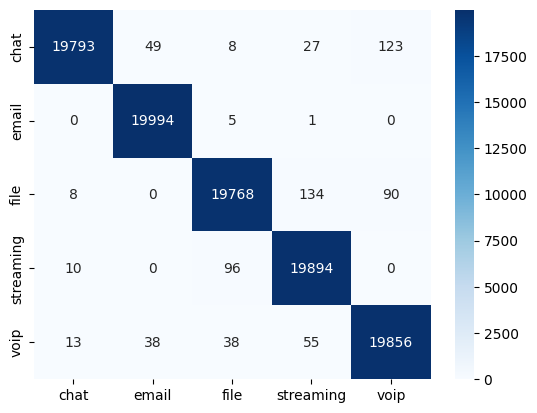

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ==========================
# 🔹 Load and Preprocess Dataset
# ==========================
LABELS_ISCX = ['chat', 'email', 'file', 'streaming', 'voip']
df_ISCX = pd.read_csv('ISCX_5class_each_normalized_cuttedfloefeature.csv')

X_ISCX = df_ISCX.iloc[:, 1:].values  # Exclude first column (assumed to be an index)
Y_ISCX = df_ISCX["label"].values  # Extract target labels

# Normalize dataset
scaler = StandardScaler()
X_ISCX = scaler.fit_transform(X_ISCX)

# Convert labels to categorical (one-hot encoding)
num_classes = len(set(Y_ISCX))
y_ISCX = tf.keras.utils.to_categorical(Y_ISCX, num_classes)

# ==========================
# 🔹 Define FGAN-II Components
# ==========================
LATENT_DIM = 100
NUM_CLIENTS = 10
BATCH_SIZE = 128
EPOCHS = 50
GENERATOR_UPDATES = 3  # Generator trains multiple times per step

# === Generator Model (Improved Stability) ===
def build_generator():
    input_g = Input(shape=(LATENT_DIM,))
    x = Dense(256, kernel_initializer="he_normal")(input_g)
    x = LeakyReLU(0.2)(x)
    x = Dense(512, kernel_initializer="he_normal")(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(X_ISCX.shape[1], activation="tanh")(x)
    return Model(input_g, x, name="FGAN2_Generator")

# === Discriminator Model (Regularized, Lower Learning Rate) ===
def build_discriminator():
    input_d = Input(shape=(X_ISCX.shape[1],))
    x = Dense(512, kernel_initializer="he_normal")(input_d)
    x = LeakyReLU(0.2)(x)
    x = Dense(256, kernel_initializer="he_normal")(x)
    x = LeakyReLU(0.2)(x)
    x = Dense(1, activation="sigmoid")(x)
    return Model(input_d, x, name="FGAN2_Discriminator")

# ==========================
# 🔹 Federated Learning Setup
# ==========================
client_models = [{"G": build_generator(), "D": build_discriminator()} for _ in range(NUM_CLIENTS)]

# Compile all discriminators with a **lower learning rate**
for client in client_models:
    client["D"].compile(loss="binary_crossentropy", optimizer=Adam(0.0001, 0.5), metrics=["accuracy"])

client_data = np.array_split(X_ISCX, NUM_CLIENTS)
client_labels = np.array_split(y_ISCX, NUM_CLIENTS)

# ==========================
# 🔹 Federated Training of FGAN-II
# ==========================
def train_fgan2(client_id):
    generator = client_models[client_id]["G"]
    discriminator = client_models[client_id]["D"]

    gan_input = Input(shape=(LATENT_DIM,))
    generated_samples = generator(gan_input)
    gan_output = discriminator(generated_samples)
    gan = Model(gan_input, gan_output)
    gan.compile(loss="mean_squared_error", optimizer=Adam(0.0001, 0.5))

    half_batch = BATCH_SIZE // 2
    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS} - Training Client {client_id+1}/{NUM_CLIENTS}")

        idx = np.random.randint(0, client_data[client_id].shape[0], half_batch)
        real_samples = client_data[client_id][idx]
        real_samples += 0.1 * np.random.normal(size=real_samples.shape)  # Add noise
        real_labels = np.ones((half_batch, 1)) * 0.95  # Label smoothing

        noise = np.random.normal(0, 1, (half_batch, LATENT_DIM))
        generated_samples = generator(noise, training=True)
        fake_labels = np.zeros((half_batch, 1)) + 0.05  # Label smoothing

        # Train Discriminator (only when necessary)
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_samples, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        for _ in range(GENERATOR_UPDATES):
            noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
            g_loss = gan.train_on_batch(noise, np.ones((BATCH_SIZE, 1)))

        print(f"Client {client_id+1}: D Loss = {d_loss[0]:.4f}, G Loss = {g_loss:.4f}")

for client_id in range(NUM_CLIENTS):
    train_fgan2(client_id)

# ==========================
# 🔹 Improved CNN Classifier
# ==========================
input_shape = (X_ISCX.shape[1], 1)
X_ISCX_reshaped = np.expand_dims(X_ISCX, axis=-1)

classifier = Sequential([
    Conv1D(64, 3, activation=LeakyReLU(alpha=0.1), padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(128, 3, activation=LeakyReLU(alpha=0.1), padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(256, 3, activation=LeakyReLU(alpha=0.1), padding='same'),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation=LeakyReLU(alpha=0.1), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

classifier.compile(optimizer=Adam(0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks: Early stopping & adaptive learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

classifier.fit(X_ISCX_reshaped, y_ISCX, epochs=50, batch_size=128, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

# ==========================
# 🔹 Classification Report & Confusion Matrix
# ==========================
y_pred = classifier.predict(X_ISCX_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_ISCX, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=LABELS_ISCX))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=LABELS_ISCX, yticklabels=LABELS_ISCX)
plt.show()


model saving and evaluation metrix output: